In [200]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.models import Sequential
from keras import applications
from keras.models import Model

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

import warnings
warnings.filterwarnings("ignore")

#### Data Preprocess (Augmentation)

In [55]:
batch_sz = 32
# Train data augmentation
train_gen = ImageDataGenerator(rescale=(1./255),
                              shear_range= 0.2,
                              horizontal_flip=True,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              fill_mode='nearest')

train_set = train_gen.flow_from_directory(directory="C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\train",
                                         target_size=(150,150),
                                         class_mode='binary',
                                         batch_size=batch_sz)

Found 6000 images belonging to 2 classes.


In [56]:
# Validation data augmentation

validate_gen = ImageDataGenerator(rescale=(1./255))

validate_set = validate_gen.flow_from_directory(directory="C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\validate",
                                               target_size=(150,150),
                                               class_mode='binary',
                                               batch_size=batch_sz)

Found 2400 images belonging to 2 classes.


In [57]:
# Test data augmentation

test_gen = ImageDataGenerator(rescale=(1./255))

test_Set = test_gen.flow_from_directory(directory="C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\test",
                                       target_size=(150,150),
                                       batch_size=batch_sz)

Found 12500 images belonging to 1 classes.


#### Model Creation

In [58]:
img_width = 150
img_height = 150
img_channel = 3

nb_train_img = 6000
nb_validate_img = 1200
nb_test_img = 12500

In [59]:
classifier = Sequential()

classifier.add(Convolution2D(32,(3,3),input_shape=(150,150,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2))) #if stride not given it equal to pool filter size
classifier.add(Dropout(rate=0.25))

classifier.add(Convolution2D(64,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(rate=0.25))

classifier.add(Convolution2D(128, (3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(rate=0.25))

classifier.add(Flatten())
classifier.add(Dense(units=512,activation='relu'))
classifier.add(Dropout(rate=0.25))

classifier.add(Dense(1,activation='sigmoid'))

classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
classifier.fit_generator(generator=train_set,
                         steps_per_epoch=6000//batch_sz,
                         epochs=50,
                         validation_data=validate_set,
                         validation_steps=2400//batch_sz)

Epoch 1/50
187/187 [==============================] - 206s 1s/step - loss: 0.7153 - acc: 0.5214 - val_loss: 0.6824 - val_acc: 0.5804
Epoch 2/50
187/187 [==============================] - 125s 668ms/step - loss: 0.6846 - acc: 0.5700 - val_loss: 0.6765 - val_acc: 0.5887
Epoch 3/50
187/187 [==============================] - 137s 731ms/step - loss: 0.6787 - acc: 0.5797 - val_loss: 0.6978 - val_acc: 0.5150
Epoch 4/50
187/187 [==============================] - 137s 732ms/step - loss: 0.6772 - acc: 0.5841 - val_loss: 0.6694 - val_acc: 0.6008
Epoch 5/50
187/187 [==============================] - 132s 706ms/step - loss: 0.6722 - acc: 0.5861 - val_loss: 0.6616 - val_acc: 0.6042
Epoch 6/50
187/187 [==============================] - 143s 764ms/step - loss: 0.6634 - acc: 0.6043 - val_loss: 0.6682 - val_acc: 0.5883
Epoch 7/50
187/187 [==============================] - 146s 783ms/step - loss: 0.6570 - acc: 0.6161 - val_loss: 0.6264 - val_acc: 0.6467
Epoch 8/50
187/187 [==============================]

1. with shuffle=False, accuracy=50, 
2. batch_sz = 16 , accuracy =  0.74
3. batch_sz = 32 , accuracy = 0.80

In [61]:
classifier.save("C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\model_scratch.h5")

#### Predicitng a Single Image

In [63]:
from keras.preprocessing import image

In [110]:
from keras.models import load_model
classifier = load_model("C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\model_scratch.h5")

In [184]:
def dog_cat_classifier(path):
    img_1 = image.load_img(path)
    plt.imshow(img_1)
    plt.axis("off")
    plt.show()
    img_1 = image.load_img(path,target_size=(150,150))
    img = image.img_to_array(img_1)   # (150, 150, 3) converting color image into array 
    img = img/255                     # (150, 150, 3) scaling down the array
    img = np.expand_dims(img, axis=0) # (1, 150, 150, 3) create a batch of size 1 [N,H,W,C]
    prediction = classifier.predict(img, batch_size=None,steps=1) # (1,1) 
    if(prediction[:,:]>0.5):
        plt.text(20, 62,"DOG",color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
        print("It's a DOG")
    else:
        plt.text(20, 62,"CAT",color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
        print("It's a CAT")
    plt.imshow(img_1)
    plt.show()

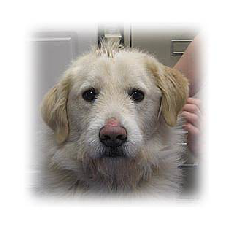

It's a DOG


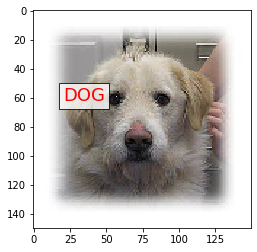

In [187]:
dir_test = "C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\test\mix\\3.jpg"
dog_cat_classifier(dir_test)

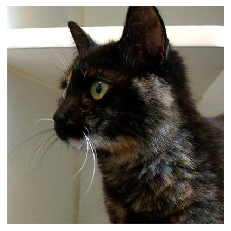

It's a CAT


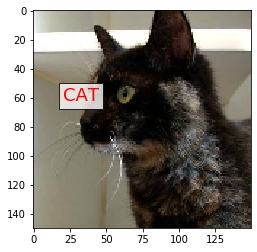

In [223]:
dir_test = "C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\test\mix\\5.jpg"
dog_cat_classifier(dir_test)

#### Predicting small dataset

In [160]:
# using the Imagedatagenerator 
print("Test image directory : ",test_Set.directory)
print("Test image shape : ",test_Set.image_shape)

Test image directory :  C:\Users\shaur\Downloads\dogs-vs-cats\test
Test image shape :  (150, 150, 3)


In [171]:
test_Set.reset
test_predict = classifier.predict_generator(generator=test_Set,steps=None)

#### Visualizing the output of different layers

Basic idea behind, visualizing the output after each and every layer is to, taking each layer as a separate 
model and predicting out test image on it and then showing the image status after every layer

In [197]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 34, 34, 128)       73856     
__________

In [198]:
classifier.layers

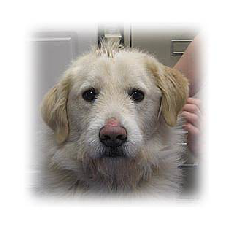

In [192]:
dir_test = "C:\\Users\\shaur\\Downloads\\dogs-vs-cats\\test\mix\\3.jpg"

x = plt.imread(dir_test)
plt.imshow(x)
plt.axis("off")
plt.show()

In [194]:
# preprcosseing img to fit to model
img_1 = image.load_img(dir_test, target_size=(150,150))
img_1 = image.img_to_array(img_1)
img_1 = img_1/255
img_1 = np.expand_dims(img_1,axis=0)
img_1.shape

(1, 150, 150, 3)

In [199]:
model_layers = [layers.name  for layers in classifier.layers]
print("Layers in model : ",model_layers)

Layers in model :  ['conv2d_34', 'max_pooling2d_34', 'dropout_45', 'conv2d_35', 'max_pooling2d_35', 'dropout_46', 'conv2d_36', 'max_pooling2d_36', 'dropout_47', 'flatten_12', 'dense_23', 'dropout_48', 'dense_24']


In [201]:
from keras.models import Model

In [206]:
conv2d_34_output = Model(inputs=classifier.input, outputs=classifier.get_layer('conv2d_34').output)
conv2d_35_output = Model(inputs=classifier.input, outputs=classifier.get_layer('conv2d_35').output)
conv2d_36_output = Model(inputs=classifier.input, outputs=classifier.get_layer("conv2d_36").output)

In [209]:
conv2d_34_features = conv2d_34_output.predict(img_1)
conv2d_35_features = conv2d_35_output.predict(img_1)
conv2d_36_features = conv2d_36_output.predict(img_1)
print('First conv layer feature output shape : ',conv2d_34_features.shape)
print('Second conv layer feature output shape : ',conv2d_35_features.shape)
print('Third conv layer feature output shape : ',conv2d_36_features.shape)

First conv layer feature output shape :  (1, 148, 148, 32)
Second conv layer feature output shape :  (1, 72, 72, 64)
Third conv layer feature output shape :  (1, 34, 34, 128)


#### 1. Single Convolution Filter Output

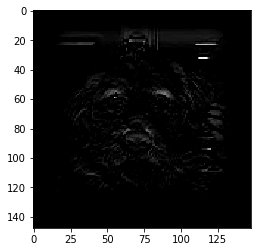

In [219]:
plt.imshow(conv2d_34_features[0, :, :, 25], cmap='gray')
plt.show()

#### 2. First Covolution Layer Output

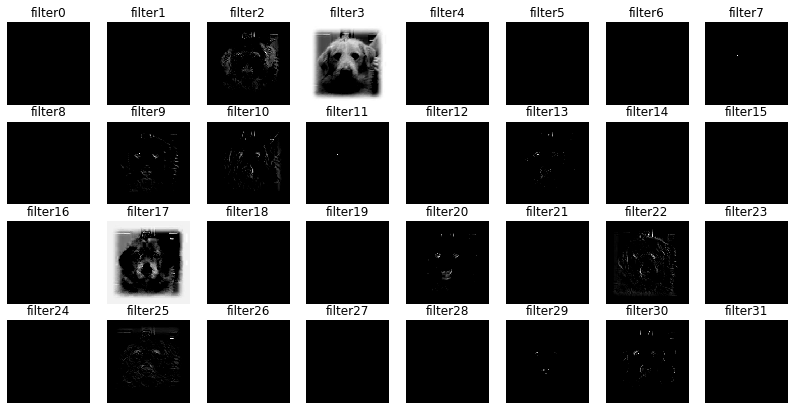

In [214]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_34_features[0, :, :, i], cmap='gray')
plt.show()

#### 3. Second Covolution Layer Output

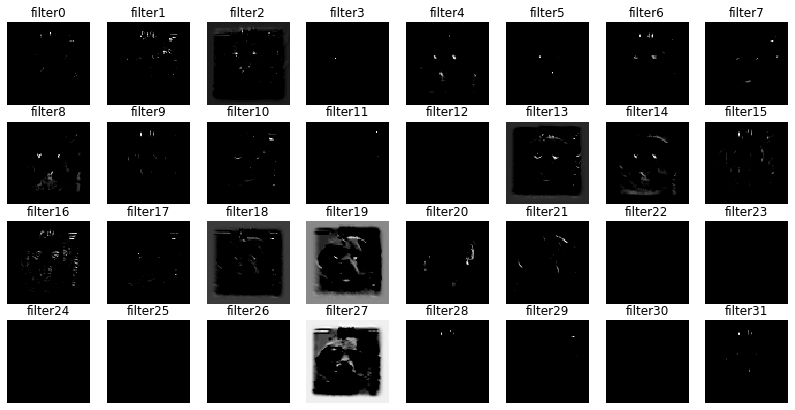

In [220]:
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_35_features[0, :, :, i], cmap='gray')
plt.show()

#### 4. Third Covolution Layer Output

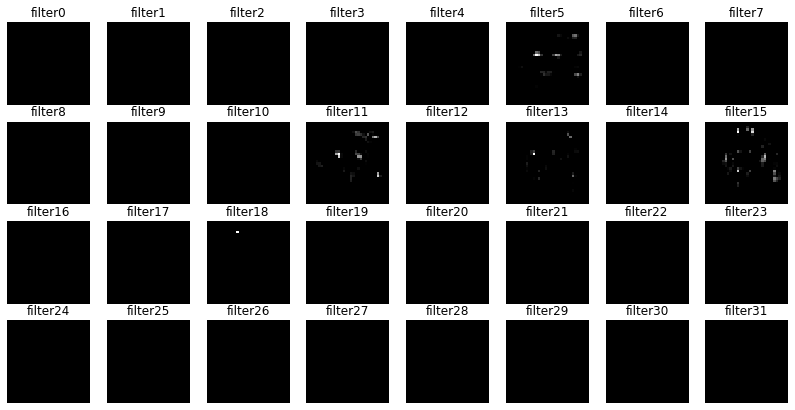

In [221]:
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_36_features[0, :, :, i], cmap='gray')
plt.show()